In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style
#from nbodykit.lab import *

from collections import OrderedDict, namedtuple
import cPickle
import glob
from matplotlib import rc
from matplotlib import rcParams
from matplotlib import spines
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, MaxNLocator
import numpy as np
import os
import random
import re
from scipy import interpolate as interp
from scipy.io import savemat
import sys
import ujson


import seaborn as sns
from matplotlib.colors import ListedColormap

#import constants
import logbook_main_calc_vel_Perr_pickles
from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.model_spec import get_trf_spec_from_list
from lsstools.results_db import retrieve_pickles
from lsstools.results_db.io import Pickler
from perr.path_utils import get_in_path
from lsstools.nbkit03_utils import apply_smoothing, catalog_persist, get_cstats_string, linear_rescale_fac, get_crms
from perr_private.model_target_pair import ModelTargetPair, Model, Target
from lsstools.sim_galaxy_catalog_creator import SimGalaxyCatalogCreator, PTChallengeGalaxiesFromRockstarHalos

from nbodykit.source.mesh.bigfile import BigFileMesh


plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
# path
basedir = '/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/'
sim_scale_factor = 0.625


# cosmology of ms_gadget sims (to compute D_lin(z))
# omega_m = 0.307494
# omega_bh2 = 0.022300
# omega_ch2 = 0.118800
# h = math.sqrt((omega_bh2 + omega_ch2) / omega_m) = 0.6774
cosmo_params = dict(Om_m=0.307494,
                   Om_L=1.0 - 0.307494,
                   Om_K=0.0,
                   Om_r=0.0,
                   h0=0.6774)

f_log_growth = np.sqrt(0.61826)


# Eulerian smoothing for model, applied here in notebook
#kmax_Eul_model_lst = [0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
kmax_Eul_model_lst = [0.04, 0.5, 1.0]

# Smoothings in lagrangian space, in Mpc/h
Rsmooth_density_to_shift = 0.0   # 0.0 before 30/3/2020
Rsmooth_displacement_source = 0.23   # 0.23 before 30/3/2020

Ngrid = 512

# Options for shifted field
ShiftedFieldsNp = 1536
ShiftedFieldsNmesh = 1536


# avg or sum. Should use avg to get correct velocity model.
PsiDot_weighted_CIC_mode = 'avg'


# Below, 'D' stands for RSD displacement in Mpc/h: D=v/(aH)=f*PsiDot.
tex_names = {}

## Targets
# DM subsample
DM_D0 = Target(
    name='DM_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40400.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity',
    val_component=0,
    rescale_factor='RSDFactor'
)

# FOF halos with peak position and peak velocity
halos_kwargs1 = dict(
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25' % sim_scale_factor),
    position_column='PeakPosition',
    val_column='PeakVelocity',
    val_component=0,
    rescale_factor='RSDFactor', # get v/(aH) in Mpc/h, where v=a dx/dt. Velocities in our MP-Gadget snapshots and fof files are a^2 dx/dt, so RSDFactor=1/(a^2H).)
)
Mmin, Mmax = 10.8,11.8
halos_108_118_D0 = Target(
    name='halos_%.1f_%.1f_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax)],
    **halos_kwargs1)
Mmin, Mmax = 11.8,12.8
halos_118_128_D0 = Target(
    name='halos_%.1f_%.1f_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax)],
    **halos_kwargs1)
Mmin, Mmax = 12.8,16.0
halos_128_160_D0 = Target(
    name='halos_%.1f_%.1f_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax)],
    **halos_kwargs1)


# FOF halos with CM position and CM velocity
halos_kwargs2 = dict(
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25' % sim_scale_factor),
    position_column='CMPosition',
    val_column='CMVelocity',
    val_component=0,
    rescale_factor='RSDFactor', # get v/(aH) in Mpc/h, where v=a dx/dt. Velocities in our MP-Gadget snapshots and fof files are a^2 dx/dt, so RSDFactor=1/(a^2H).)
)
Mmin, Mmax = 10.8,11.8
CM_halos_108_118_D0 = Target(
    name='CM_halos_%.1f_%.1f_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax)],
    **halos_kwargs2)
Mmin, Mmax = 11.8,12.8
CM_halos_118_128_D0 = Target(
    name='CM_halos_%.1f_%.1f_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax)],
    **halos_kwargs2)
Mmin, Mmax = 12.8,16.0
CM_halos_128_160_D0 = Target(
    name='CM_halos_%.1f_%.1f_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax)],
    **halos_kwargs2)

# also subboxes D0
Mmin, Mmax = 10.8,11.8
CM_halos_108_118_subbox_D0 = Target(
    name='CM_halos_%.1f_%.1f_subbox_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax), ('CMPosition', 'max', [100.,100.,20.])],
    **halos_kwargs2)
Mmin, Mmax = 11.8,12.8
CM_halos_118_128_subbox_D0 = Target(
    name='CM_halos_%.1f_%.1f_subbox_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax), ('CMPosition', 'max', [100.,100.,20.])],
    **halos_kwargs2)
Mmin, Mmax = 12.8,16.0
CM_halos_128_160_subbox_D0 = Target(
    name='CM_halos_%.1f_%.1f_subbox_D0' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax), ('CMPosition', 'max', [100.,100.,20.])],
    **halos_kwargs2)

# also subboxes D1
halos_kwargs3 = dict(
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25' % sim_scale_factor),
    position_column='CMPosition',
    val_column='CMVelocity',
    val_component=1,
    rescale_factor='RSDFactor', # get v/(aH) in Mpc/h, where v=a dx/dt. Velocities in our MP-Gadget snapshots and fof files are a^2 dx/dt, so RSDFactor=1/(a^2H).)
)
Mmin, Mmax = 10.8,11.8
CM_halos_108_118_subbox_D1 = Target(
    name='CM_halos_%.1f_%.1f_subbox_D1' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax), ('CMPosition', 'max', [100.,100.,20.])],
    **halos_kwargs3)
Mmin, Mmax = 11.8,12.8
CM_halos_118_128_subbox_D1 = Target(
    name='CM_halos_%.1f_%.1f_subbox_D1' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax), ('CMPosition', 'max', [100.,100.,20.])],
    **halos_kwargs3)
Mmin, Mmax = 12.8,16.0
CM_halos_128_160_subbox_D1 = Target(
    name='CM_halos_%.1f_%.1f_subbox_D1' % (Mmin, Mmax),  cuts=[('log10M', 'min', Mmin), ('log10M', 'max', Mmax), ('CMPosition', 'max', [100.,100.,20.])],
    **halos_kwargs3)



# subbox of FOF halos
halo_subbox_D0 = Target(
    name='halo_subbox_D0',
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25' % sim_scale_factor),
    position_column='PeakPosition',
    val_column='PeakVelocity',
    val_component=0,
    rescale_factor='RSDFactor',
    cuts=[('log10M', 'min', 10.8),
          ('log10M', 'max', 11.8),
          ('CMPosition', 'max', [100.,100.,20.])
         ]
    )


# Zheng07_HandSeljak17 HOD galaxies
gal_HOD_Zheng07_HandSeljak17_D0 = Target(
    name = 'gal_HOD_Zheng07_HandSeljak17_D0',
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25_mvir_HOD_Zheng07_HandSeljak17.bigfile' % sim_scale_factor),    
    position_column='Position',
    #val_column='VelocityOffset', rescale_factor=1.0, # VelocityOffset is RSD displacement in Mpc/h
    val_column='Velocity', rescale_factor='RSDFactor', # get RSD displacement in Mpc/h
    val_component=0     
)

# subbox of HOD galaxies
# Zheng07_HandSeljak17 HOD galaxies
gal_HOD_Zheng07_HandSeljak17_subbox_D0 = Target(
    name = 'gal_HOD_Zheng07_HandSeljak17_subbox_D0',
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25_mvir_HOD_Zheng07_HandSeljak17.bigfile' % sim_scale_factor),    
    position_column='Position',
    #val_column='VelocityOffset', rescale_factor=1.0, # VelocityOffset is RSD displacement in Mpc/h
    val_column='Velocity', rescale_factor='RSDFactor', # get RSD displacement in Mpc/h
    val_component=0,
    cuts=[('Position', 'max', [100.,100.,20.])]
)
gal_HOD_Zheng07_HandSeljak17_subbox_D1 = Target(
    name = 'gal_HOD_Zheng07_HandSeljak17_subbox_D1',
    in_fname=os.path.join(basedir, 'nbkit_fof_%.4f/ll_0.200_nmin25_mvir_HOD_Zheng07_HandSeljak17.bigfile' % sim_scale_factor),    
    position_column='Position',
    #val_column='VelocityOffset', rescale_factor=1.0, # VelocityOffset is RSD displacement in Mpc/h
    val_column='Velocity', rescale_factor='RSDFactor', # get RSD displacement in Mpc/h
    val_component=1,
    cuts=[('Position', 'max', [100.,100.,20.])]
)





# PT Challenge galaxies from rockstar halos. Rockstar gives core positions and velocities.
# Units: 1/(aH) = 1./(a * H0*np.sqrt(Om_m/a**3+Om_L)) * (H0/100.) in Mpc/h / (km/s).
# For ms_gadget, get 1/(aH) = 0.01145196 Mpc/h/(km/s) = 0.0183231*0.6250 Mpc/h/(km/s).
# Note that MP-Gadget files have RSDFactor=1/(a^2H)=0.0183231 for a=0.6250 b/c they use a^2\dot x for Velocity.
assert sim_scale_factor == 0.625
gal_ptchall_D0 = Target(
    name='gal_ptchall_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=0,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False)
         ]
    )

# subbox of PT challenge galaxies, x component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D0 = Target(
    name='gal_ptchall_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=0,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [500.,500.,20.])
         ]
    )

# subbox of PT challenge galaxies, x component, apply RSD to position (TEST)
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D0_RSDtest = Target(
    name='gal_ptchall_D0_RSDtest',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    velocity_column='Velocity', 
    apply_RSD_to_position=True,
    RSD_los=[1,0,0],
    RSDFactor=0.01145196,
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=0,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [100.,100.,20.])
         ]
    )

# subbox of PT challenge galaxies, y component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D1 = Target(
    name='gal_ptchall_D1',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=1,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [500.,500.,20.])
         ]
    )

# subbox of PT challenge galaxies, y component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D2 = Target(
    name='gal_ptchall_D2',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=2,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [500.,500.,20.])
         ]
    )


# Rockstar halos with mass cut
assert sim_scale_factor == 0.625
rockstar_kwargs = dict(
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=0,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v.     
)
Mmin, Mmax = 10.8, 11.8
rockstar_halos_108_118_D0 = Target(
    name='rockstar_halos_%.1f_%.1f_D0' % (Mmin, Mmax), cuts=[('log10Mvir', 'min', Mmin), ('log10Mvir', 'max', Mmax)],
    **rockstar_kwargs)
Mmin, Mmax = 11.8, 12.8
rockstar_halos_118_128_D0 = Target(
    name='rockstar_halos_%.1f_%.1f_D0' % (Mmin, Mmax), cuts=[('log10Mvir', 'min', Mmin), ('log10Mvir', 'max', Mmax)],
    **rockstar_kwargs)
Mmin, Mmax = 12.8, 16.0
rockstar_halos_128_160_D0 = Target(
    name='rockstar_halos_%.1f_%.1f_D0' % (Mmin, Mmax), cuts=[('log10Mvir', 'min', Mmin), ('log10Mvir', 'max', Mmax)],
    **rockstar_kwargs)

# subbox of rockstar halos with mass cut
Mmin, Mmax = 12.8, 16.0
rockstar_halos_128_160_subbox_D0 = Target(
    name='rockstar_halos_%.1f_%.1f_subbox_D0' % (Mmin, Mmax), cuts=[('log10Mvir', 'min', Mmin), ('log10Mvir', 'max', Mmax), ('Position', 'max', [100.,100.,20.])],
    **rockstar_kwargs)
rockstar_halos_128_160_subbox_D1 = Target(
    name='rockstar_halos_%.1f_%.1f_subbox_D0' % (Mmin, Mmax), cuts=[('log10Mvir', 'min', Mmin), ('log10Mvir', 'max', Mmax), ('Position', 'max', [100.,100.,20.])],
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=1,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v.  
)




In [50]:
### Models

# 1st order PsiDot shifted by linear Psi
s = ('IC_LinearMesh_PsiDot1_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_D0 = Model(
    name='PsiDot1_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot1_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_D1 = Model(
    name='PsiDot1_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# z direction
s = ('IC_LinearMesh_PsiDot1_2_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_D2 = Model(
    name='PsiDot1_D2',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# 2nd order PsiDot shifted by 2nd order Psi
s = ('IC_LinearMesh_PsiDot2_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_D0 = Model(
    name='PsiDot2_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot2_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_D1 = Model(
    name='PsiDot2_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# 2nd order PsiDot shifted by 1st order Psi
s = ('IC_LinearMesh_PsiDot2_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_shiftedbyPsi1_D0 = Model(
    name='PsiDot2_shiftedbyPsi1_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot2_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_shiftedbyPsi1_D1 = Model(
    name='PsiDot2_shiftedbyPsi1_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# Linear PsiDot shifted by 2nd order Psi
s = ('IC_LinearMesh_PsiDot1_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_shiftedbyPsi2_D0 = Model(
    name='PsiDot1_shiftedbyPsi2_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot1_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_shiftedbyPsi2_D1 = Model(
    name='PsiDot1_shiftedbyPsi2_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# k/k^2 deltaZ, x direction
def k0ovksq_filter_fcn(k, v, d=0):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))

s = '1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
deltaZ_D0 = Model(
    name='deltaZ_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    #read_mode='density',
    read_mode='delta from 1+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')

# k/k^2 deltaZ, y direction
def k1ovksq_filter_fcn(k, v, d=1):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))

s = '1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
deltaZ_D1 = Model(
    name='deltaZ_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='delta from 1+delta',
    filters=[k1ovksq_filter_fcn],
    readout_window='cic')


# k/k^2 delta2LPT, x direction
def k0ovksq_filter_fcn(k, v, d=0):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))

s = '1_intR0.00_extR%.2f_SHIFTEDBY_Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
delta2LPT_D0 = Model(
    name='delta2LPT_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    #read_mode='density',
    read_mode='delta from 1+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')


# k/k^2 delta_lin
z_rescalefac = linear_rescale_fac(current_scale_factor=1.0,
                                  desired_scale_factor=sim_scale_factor,
                                  cosmo_params=cosmo_params)
print('z_rescalefac for linear density:', z_rescalefac)
deltalin_D0 = Model(
    name='deltalin_D0',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth*z_rescalefac,
    read_mode='density',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')
deltalin_D1 = Model(
    name='deltalin_D1',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth*z_rescalefac,
    read_mode='density',
    filters=[k1ovksq_filter_fcn],
    readout_window='cic')


# k/k^2 G2[delta_lin(z=0.6)] -- note theta2 already rescales to z=0.6 internally
theta2_of_deltalin_D0 = Model(
    name='theta2_of_deltalin_D0',
    in_fname=os.path.join(basedir, 'theta2_of_IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth,
    read_mode='delta from 1+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')
theta2_of_deltalin_D1 = Model(
    name='theta2_of_deltalin_D1',
    in_fname=os.path.join(basedir, 'theta2_of_IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth,
    read_mode='delta from 1+delta',
    filters=[k1ovksq_filter_fcn],
    readout_window='cic')

# k/k^2 G2[delta_Z(z=0.6)] -- note theta2 already rescales to z=0.6 internally
s = '1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
theta2_of_deltaZ_D0 = Model(
    name='theta2_of_deltaZ_D0',
    in_fname=os.path.join(basedir, 'theta2_of_%s' % s),
    rescale_factor=f_log_growth,
    read_mode='delta from 1+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')
theta2_of_deltaZ_D1 = Model(
    name='theta2_of_deltaZ_D1',
    in_fname=os.path.join(basedir, 'theta2_of_%s' % s),
    rescale_factor=f_log_growth,
    read_mode='delta from 1+delta',
    filters=[k1ovksq_filter_fcn],
    readout_window='cic')

z_rescalefac for linear density: 0.7336055475440896


## Histograms ##

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_PsiDot1_0_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICavg
Apply rescale fac to PsiDot1_D0: 0.786295109993697
MESH PsiDot1_D0: rms, min, mean, max: 3.22473 -15.2871 -7.10665e-05 14.8861

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
Cuts removed -99.4867% of objects
Apply rescale factor: 0.011452
TARGET CATALOG gal_ptchall_D0: rms, min, mean, max: 3.86053 -28.1726 -0.0247806 37.8329

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
Cuts removed -99.4867% of objects
Apply rescale factor: 0.011452
T

/Users/mschmittfull/anaconda/anaconda2/envs/nbodykit-0.3.7-env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


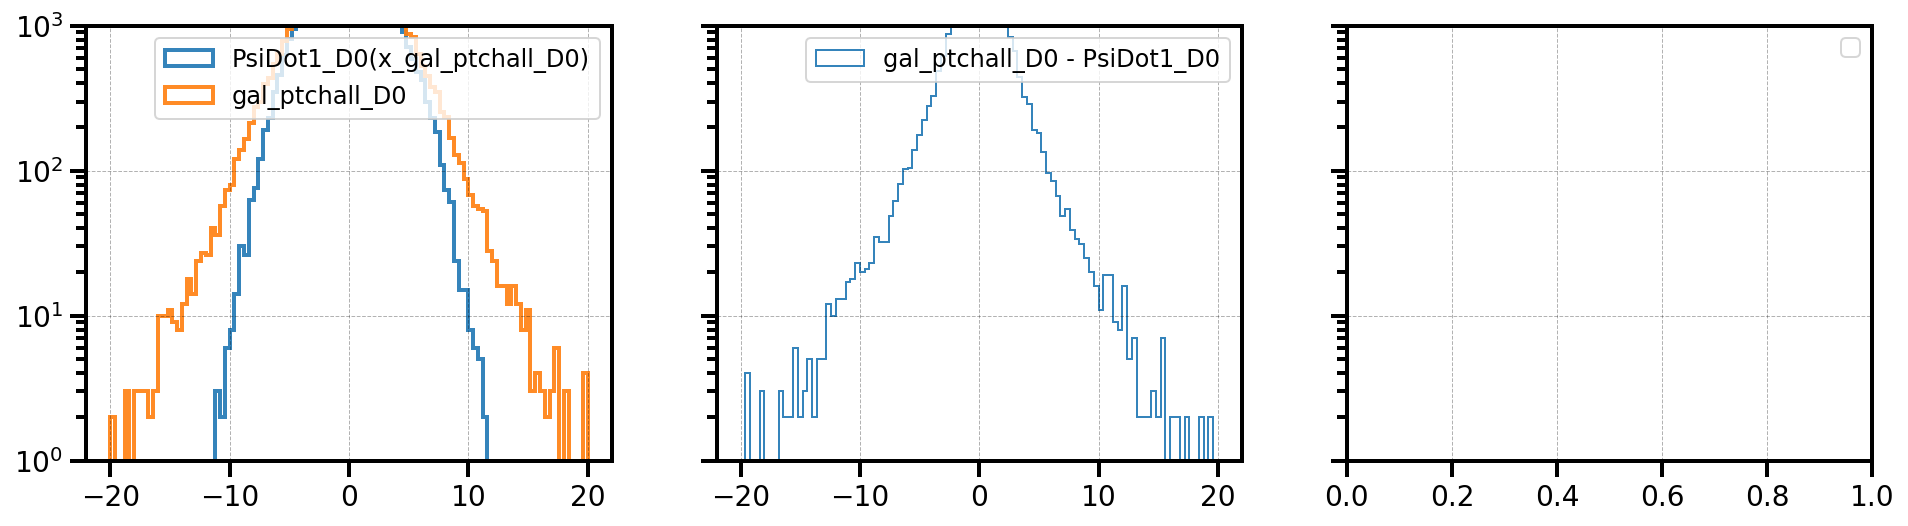

In [4]:
if True:
    ## ModelTargetPairs to plot
    model_target_pairs = []

    # PTchallenge galaxies
    model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=gal_ptchall_D0))
            
    if False:
        # Rockstar halos with mass cut
        for target in [rockstar_halos_108_118_D0, rockstar_halos_118_128_D0, rockstar_halos_128_160_D0
        ]:
            model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))
    

    vmin, vmax = -20, 20

    fig, axarr = plt.subplots(1, 3,
                              figsize=(16, 4),
                              sharey=True,
                              sharex=False)

    for mtp in model_target_pairs:
        Dmodel = mtp.readout_model_at_target_pos()
        Dtarget = mtp.get_target_val_at_target_pos().compute()

        ax = axarr[0]
        ax.hist(Dmodel, bins=100, normed=False, range=(vmin,vmax), 
                 histtype='step', lw=2, alpha=0.9,
                 label='%s(x_%s)' % (mtp.model.name, mtp.target.name))

        ax = axarr[0]
        ax.hist(Dtarget, bins=100, normed=False, range=(vmin,vmax), 
                 histtype='step', lw=2, alpha=0.9,
                 label=mtp.target.name)

        ax = axarr[1]
        ax.hist(Dtarget-Dmodel, bins=100, normed=False, range=(vmin,vmax), 
                 histtype='step', lw=1, alpha=0.9,
                 label='%s - %s' % (mtp.target.name,mtp.model.name))

        #del Dmodel, Dtarget

    for ax in axarr:
        ax.set_yscale('log')
        ax.set_ylim((1,1000))
        ax.legend(loc='best', fontsize=12);
        

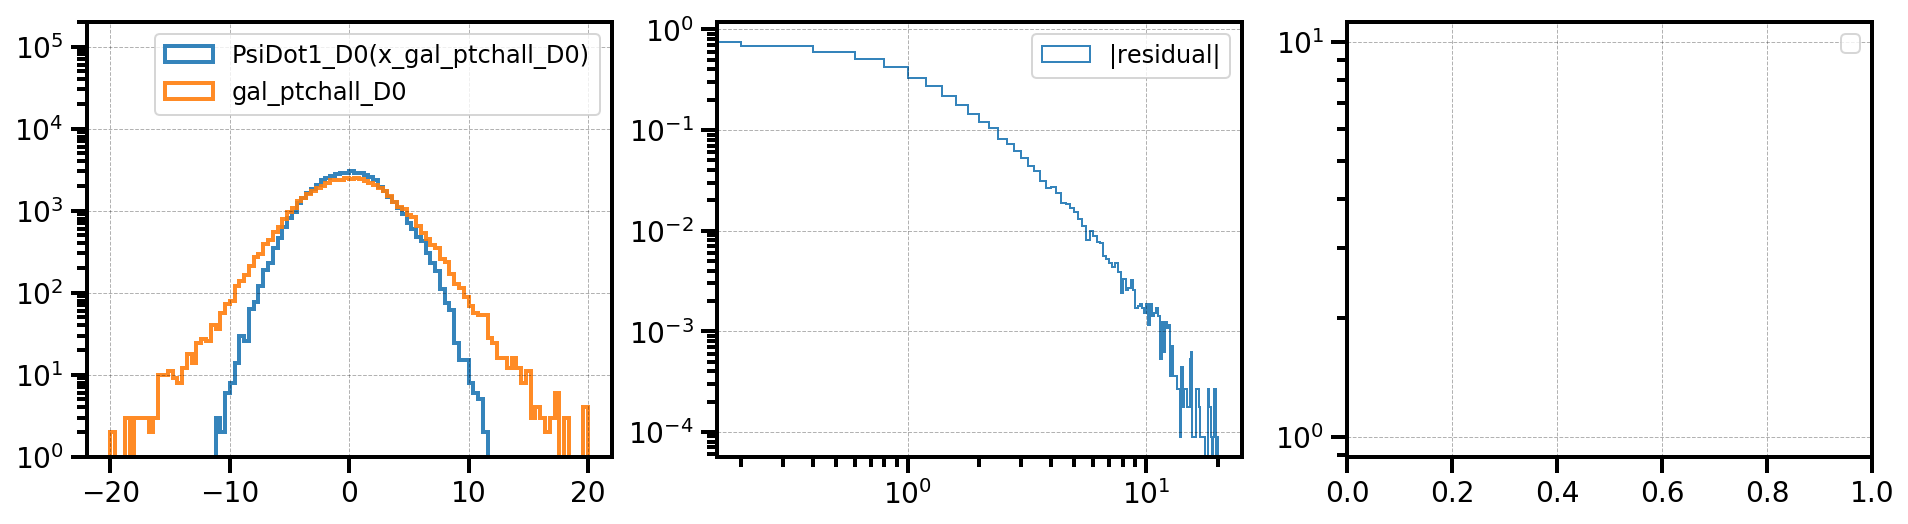

In [5]:
if True:
    # replot last from memory

    vmin, vmax = -20, 20

    fig, axarr = plt.subplots(1, 3,
                              figsize=(16, 4),
                              sharey=False,
                              sharex=False)

    ax = axarr[0]
    ax.hist(Dmodel, bins=100, normed=False, range=(vmin,vmax), 
             histtype='step', lw=2, alpha=0.9,
             label='%s(x_%s)' % (mtp.model.name, mtp.target.name))

    ax = axarr[0]
    ax.hist(Dtarget, bins=100, normed=False, range=(vmin,vmax), 
             histtype='step', lw=2, alpha=0.9,
             label=mtp.target.name)

    ax = axarr[1]
    ax.hist(np.abs(Dtarget-Dmodel), bins=100,  range=(0,vmax), 
             histtype='step', lw=1, alpha=0.9, density=True,
             label='|residual|')


    for ax in axarr:
        ax.set_yscale('log')
        axarr[0].set_ylim((1,2e5))
        ax.legend(loc='best', fontsize=12);
        
    axarr[1].set_xscale('log')
        

In [6]:
del Dmodel, Dtarget

## Slices ##

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_PsiDot1_0_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICavg
Apply rescale fac to PsiDot1_D0: 0.786295109993697
MESH PsiDot1_D0: rms, min, mean, max: 3.22473 -15.2871 -7.10665e-05 14.8861

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
cut: Position max [500.0, 500.0, 20.0]
Cuts removed -99.9784% of objects
Apply rescale factor: 0.011452
TARGET CATALOG gal_ptchall_D0: rms, min, mean, max: 3.71641 -23.2732 -0.0153313 17.1459

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
cut: Position max [500.0, 5

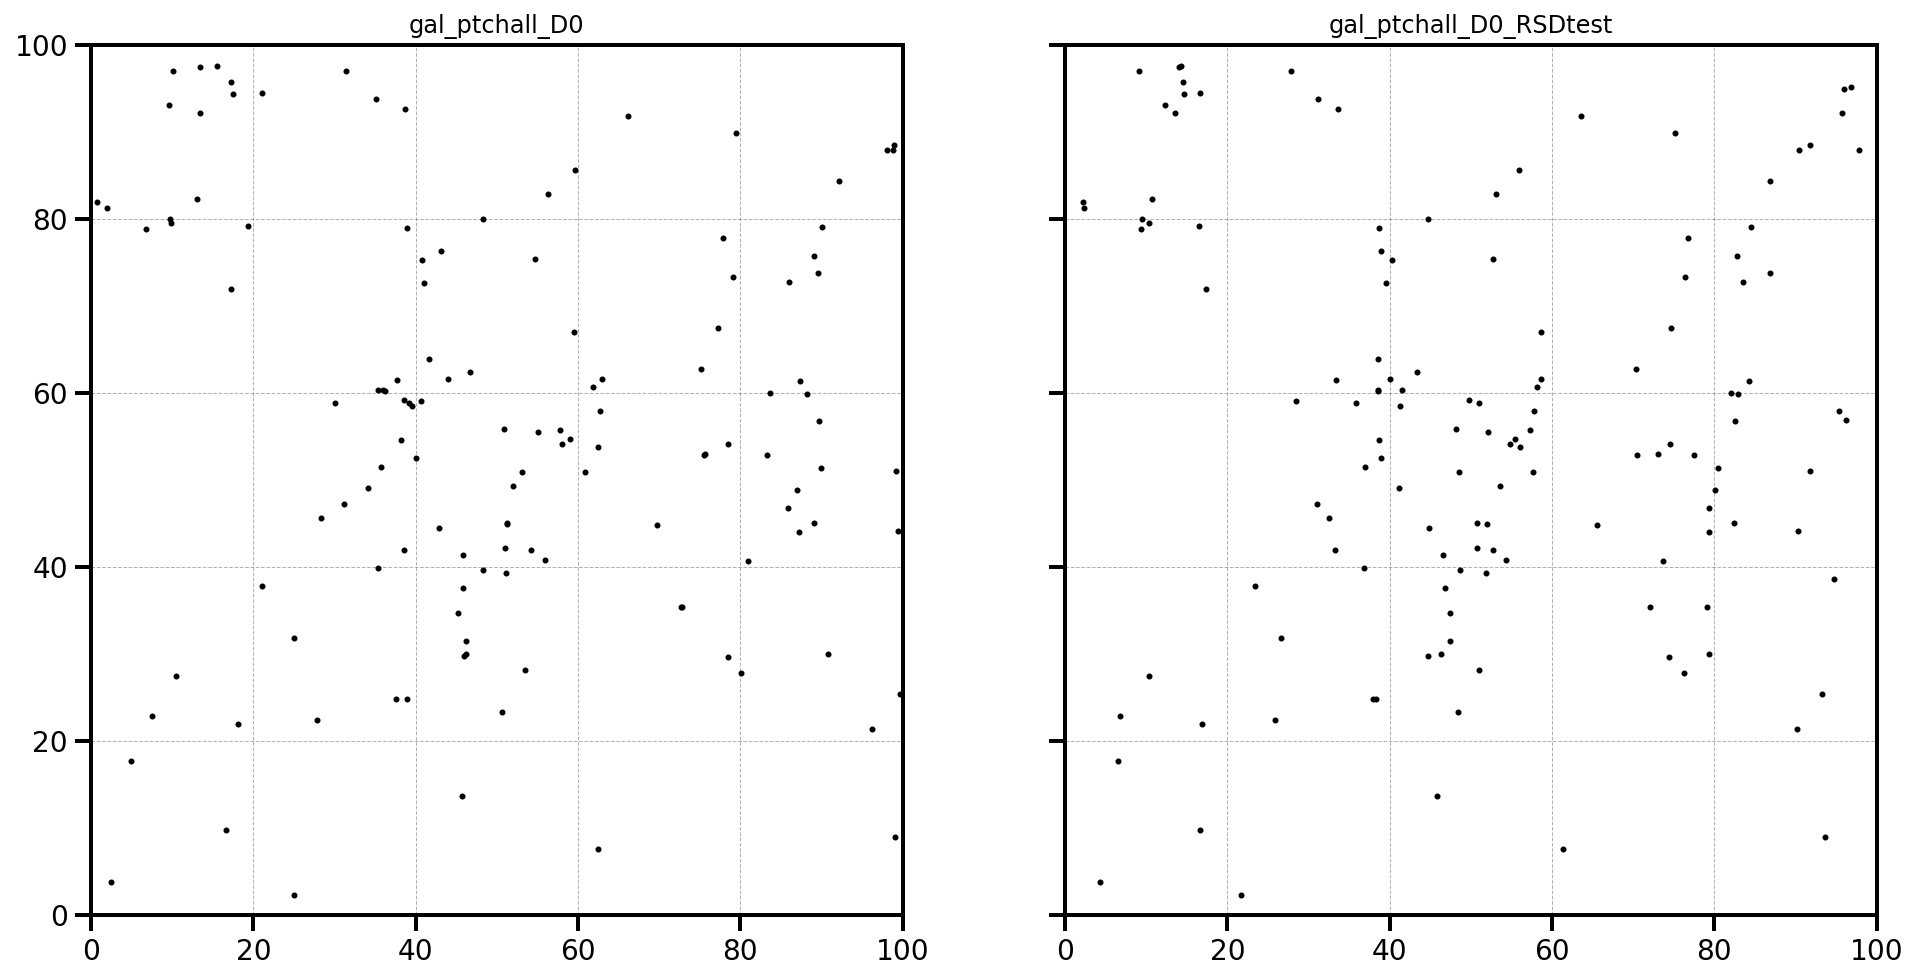

In [7]:
if True:
    ## ModelTargetPairs to plot
    model_target_pairs = []

#     # Model=PsiDot, target=FOF halo velocity
#     model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=halo_subbox_D0))
#     model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=halo_subbox_D0))
#     model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=halo_subbox_D0))


    if True:
        # PTchallenge galaxies
        model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=gal_ptchall_subbox_D0))
        model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=gal_ptchall_subbox_D0_RSDtest))
            
    if False:
        # Rockstar halos with mass cut
        for target in [rockstar_halos_108_118_D0, rockstar_halos_118_128_D0, rockstar_halos_128_160_D0
        ]:
            model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))



    vmin, vmax = -5, 5

    fig, axarr = plt.subplots(1, 2,
                              figsize=(16, 8),
                              sharey=True,
                              sharex=False)

    for counter, mtp in enumerate(model_target_pairs):
        Dmodel = mtp.readout_model_at_target_pos()
        Dtarget = mtp.get_target_val_at_target_pos()
        target_cat = mtp.target.get_catalog()

        residual = Dtarget - 0*Dmodel

        ax = axarr[counter]
        plot = ax.scatter(target_cat['Position'][:,0], target_cat['Position'][:,1], s=4, 
                          c='k',
                          #c=residual, # RSD_displacement from PsiDot in Mpc/h = f*PsiDot_code
                         vmin=vmin, vmax=vmax)
        ax.set_xlim((0,100))
        ax.set_ylim((0,100))
        #ax.set_title('%s - %s' % (mtp.target.name, mtp.model.name), fontsize=12)
        ax.set_title('%s' % (mtp.target.name), fontsize=12)
        
        #plt.colorbar(plot, ax=ax, shrink=0.95)

        #del Dmodel, Dtarget, residual

    #for ax in axarr:
    #    ax.legend(loc='best', fontsize=12);
    fname = '../pdf/slice_residual_compare_models.pdf'
    plt.savefig(fname)
    print('Saved %s' % fname)

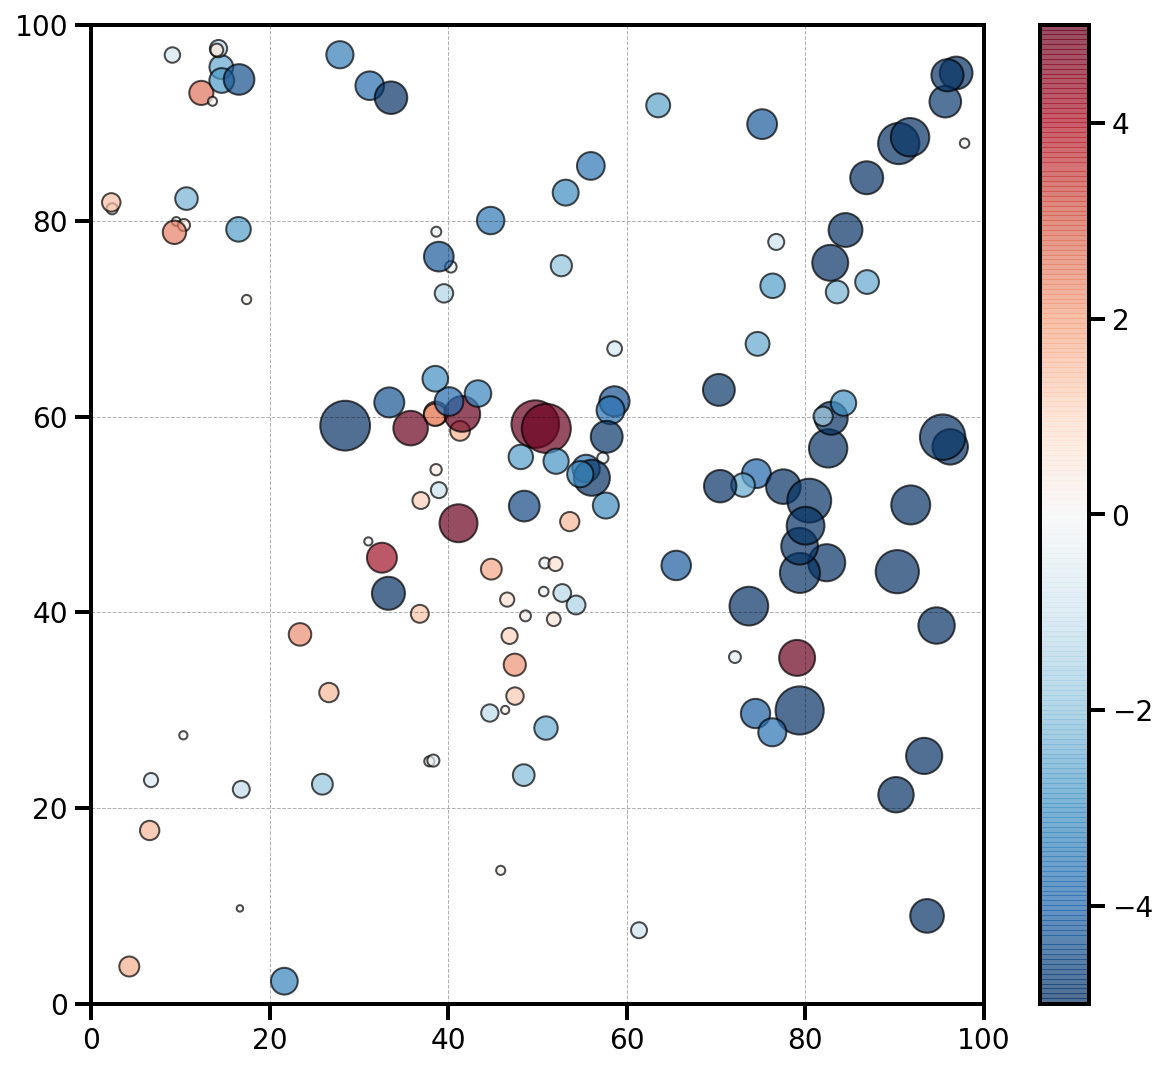

In [8]:


#cpal = sns.diverging_palette(255, 133, l=60, n=7, center="dark")
cpal = sns.color_palette("RdBu_r", 200)
#cpal = sns.color_palette("coolwarm", 200)


fig = plt.figure(figsize=(10,9))
ax = plt.gca()
plot = ax.scatter(target_cat['Position'][:,0], target_cat['Position'][:,1], s=10+50*np.abs(residual), alpha=0.7,
                          c=residual, # RSD_displacement from PsiDot in Mpc/h = f*PsiDot_code
                  linewidth=1,edgecolors='k', 
                  cmap=ListedColormap(cpal.as_hex()),
                  #cmap='coolwarm',
                         vmin=vmin, vmax=vmax)
ax.set_xlim((0,100));
ax.set_ylim((0,100));
plt.colorbar(plot, ax=ax);

## Vector plot of displacements: target, model, residual ##

In [9]:
def plot_vectors(D0_target_cat, D0_target, D1_target, D2_target, D0_model, D1_model, D2_model, mtp_D0):

    fig, axarr = plt.subplots(1,3, figsize=(16,6), sharex=True,  sharey=True)

    plt_kwargs = dict(#cmap=ListedColormap(cpal.as_hex()),
                            angles='xy', scale_units='xy', scale=1,  # length of vectors in Mpc/h
                             alpha=1, headwidth=3)

    # target
    ax = axarr[0]
    plot = ax.quiver(D0_target_cat['Position'][:,0], D0_target_cat['Position'][:,1], 
                     D0_target, D1_target,
                     color='k',
                     #D2_target, # color
                     width=0.003,
                     **plt_kwargs);
    ax.set_title(mtp_D0.target.name[:-3], fontsize=16)   


    # model
    ax = axarr[1]
    plot = ax.quiver(D0_target_cat['Position'][:,0], D0_target_cat['Position'][:,1], 
                     D0_model, D1_model,
                     color='k',
                     #D2_model, # color
                     width=0.003,
                     **plt_kwargs);
    ax.set_title(mtp_D0.model.name[:-3], fontsize=16)
    
  
    # residual
    ax = axarr[2]
    plot = ax.quiver(D0_target_cat['Position'][:,0], D0_target_cat['Position'][:,1], 
                     residual_D0, residual_D1,
                     color='k',
                     #residual_D2, # color
                     width=0.003,
                     **plt_kwargs);
    ax.set_title('Residual', fontsize=16)

    # cosmetics
    axarr[0].set_ylabel(r'y [Mpc/h]')
    for ax in axarr:
        ax.set_xlim((0,100))
        ax.set_ylim((0,100))
        ax.set_xlabel(r'$x$ [Mpc/h]')
    plt.tight_layout()

    fname = '../pdf/slice_vectors_%s_%s.pdf' % (mtp_D0.target.name[:-3],mtp_D0.model.name[:-3])
    plt.savefig(fname)
    print('Saved %s' % fname)
    


In [10]:
if True:
    # plot from memory without recomputing fields
    plot_vectors(D0_target_cat, D0_target, D1_target, D2_target, D0_model, D1_model, D2_model, mtp_D0)

NameError: name 'D0_target_cat' is not defined

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_PsiDot1_0_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICavg
Apply rescale fac to PsiDot1_D0: 0.786295109993697
MESH PsiDot1_D0: rms, min, mean, max: 3.22473 -15.2871 -7.10665e-05 14.8861

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
cut: Position max [500.0, 500.0, 20.0]
Cuts removed -99.9784% of objects
Apply rescale factor: 0.011452
TARGET CATALOG gal_ptchall_D0: rms, min, mean, max: 3.71641 -23.2732 -0.0153313 17.1459

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
cut: Position max [500.0, 5

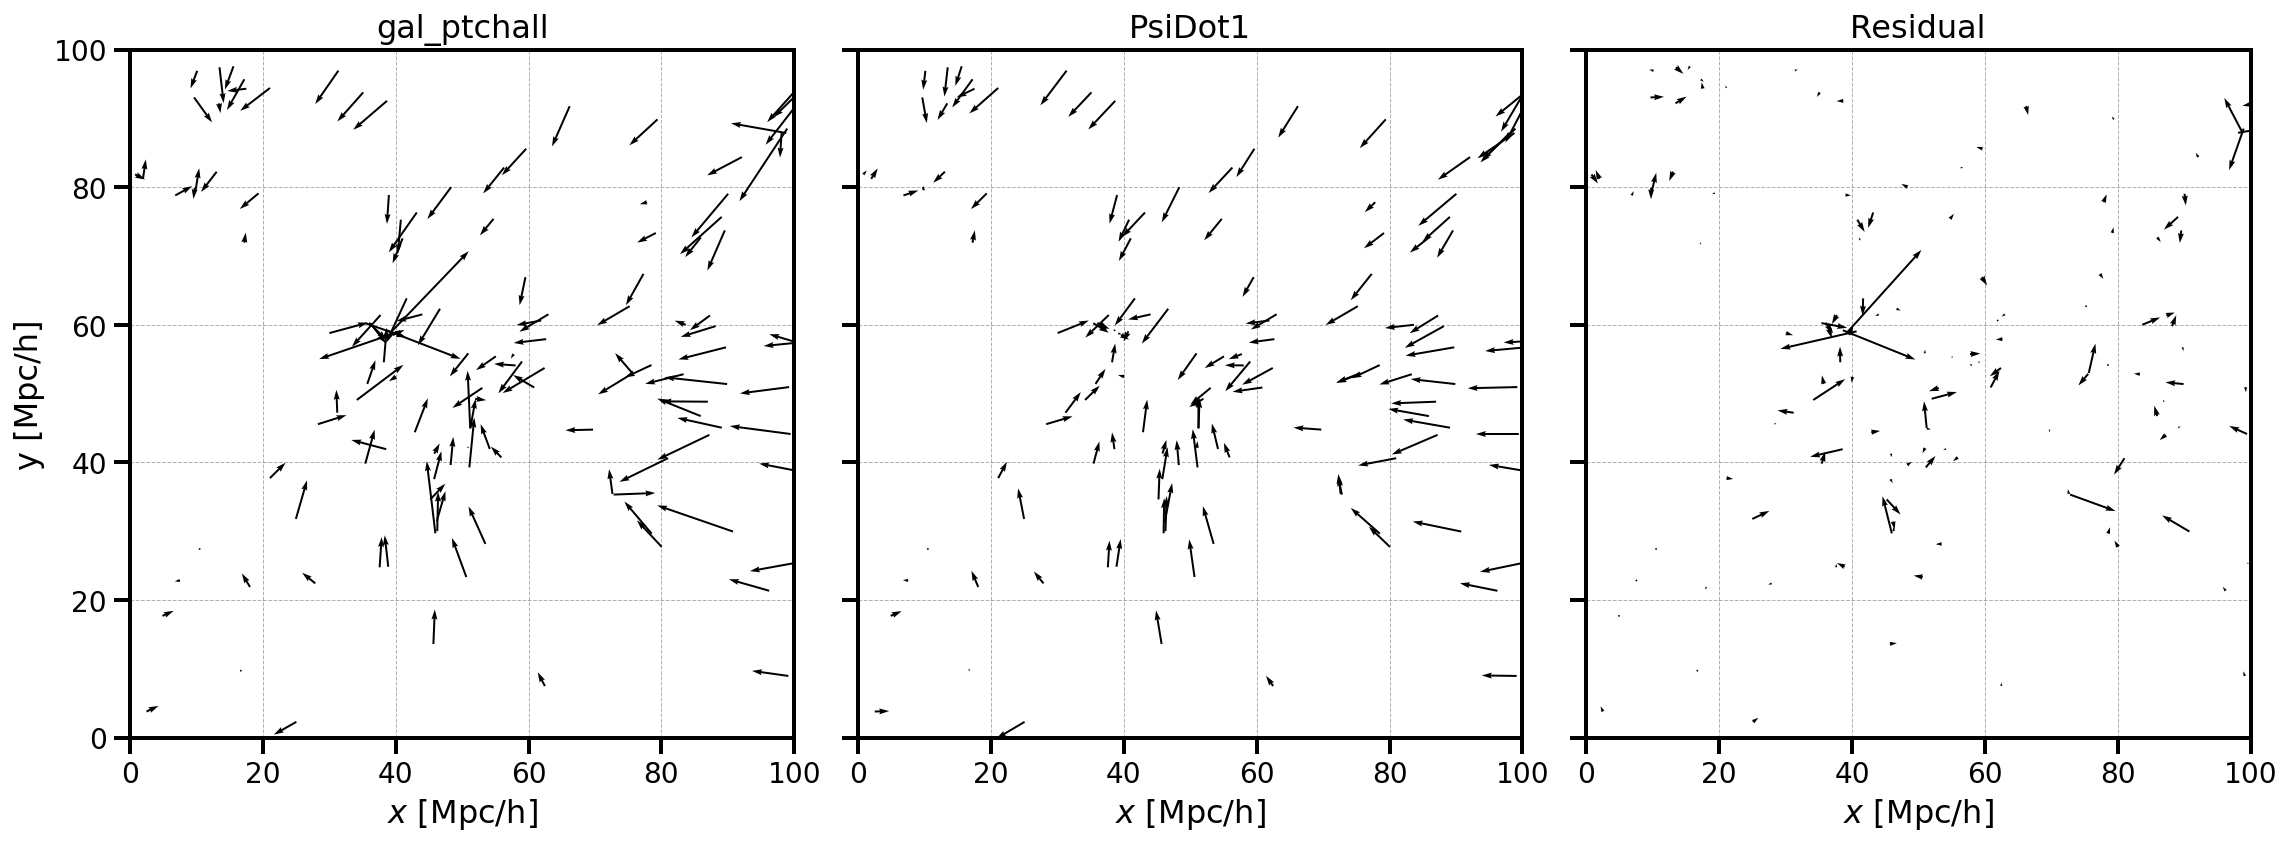

In [11]:
# Compute fields from scratch and do vector plot
if True:
    ## ModelTargetPairs to plot
    model_target_pairs_D0 = [] # x component of displacement
    model_target_pairs_D1 = [] # y component of displacement
    model_target_pairs_D2 = [] # y component of displacement


    if True:
        # PTchallenge galaxies, PsiDot model
        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot1_D0, target=gal_ptchall_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot1_D1, target=gal_ptchall_subbox_D1))
        model_target_pairs_D2.append(ModelTargetPair(model=PsiDot1_D2, target=gal_ptchall_subbox_D2))

    if False:
        # PTchallenge galaxies, 2nd order PsiDot model
        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot2_D0, target=gal_ptchall_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot2_D1, target=gal_ptchall_subbox_D1))
        
    if False:
        # PTchallenge galaxies, G2[delta_Z] model
        model_target_pairs_D0.append(ModelTargetPair(model=theta2_of_deltaZ_D0, target=gal_ptchall_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=theta2_of_deltaZ_D1, target=gal_ptchall_subbox_D1))
        
        
        
    if False:
        # PTchallenge galaxies, deltaZ or deltalin model
        model_target_pairs_D0.append(ModelTargetPair(model=deltalin_D0, target=gal_ptchall_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=deltalin_D1, target=gal_ptchall_subbox_D1))

    if False:
        # rockstar halos with mass cut
        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot1_D0, target=rockstar_halos_128_160_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot1_D1, target=rockstar_halos_128_160_subbox_D1))

        
        
    if False:
        # FOF halos with CM position and velocity 
        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot1_D0, target=CM_halos_108_118_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot1_D1, target=CM_halos_108_118_subbox_D1))

        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot1_D0, target=CM_halos_118_128_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot1_D1, target=CM_halos_118_128_subbox_D1))
        
        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot1_D0, target=CM_halos_128_160_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot1_D1, target=CM_halos_128_160_subbox_D1))

    if False:
        # FOF HOD
        model_target_pairs_D0.append(ModelTargetPair(model=PsiDot1_D0, target=gal_HOD_Zheng07_HandSeljak17_subbox_D0))
        model_target_pairs_D1.append(ModelTargetPair(model=PsiDot1_D1, target=gal_HOD_Zheng07_HandSeljak17_subbox_D1))


    cpal = sns.diverging_palette(255, 133, l=60, n=7, center="dark")
    #cpal = sns.color_palette("RdBu_r", 200)
    #cpal = sns.color_palette("coolwarm", 200)
    vmin, vmax = -5, 5


    for counter in range(len(model_target_pairs_D0)):
        mtp_D0 = model_target_pairs_D0[counter]
        mtp_D1 = model_target_pairs_D1[counter]
        mtp_D2 = model_target_pairs_D2[counter]
    
        D0_model = mtp_D0.readout_model_at_target_pos()
        D0_target = mtp_D0.get_target_val_at_target_pos()
        D0_target_cat = mtp_D0.target.get_catalog()
        residual_D0 = D0_target - D0_model
        
        D1_model = mtp_D1.readout_model_at_target_pos()
        D1_target = mtp_D1.get_target_val_at_target_pos()
        D1_target_cat = mtp_D1.target.get_catalog()
        residual_D1 = D1_target - D1_model

        D2_model = mtp_D2.readout_model_at_target_pos()
        D2_target = mtp_D2.get_target_val_at_target_pos()
        D2_target_cat = mtp_D2.target.get_catalog()
        residual_D2 = D2_target - D2_model
        
        plot_vectors(D0_target_cat, D0_target, D1_target, D2_target, D0_model, D1_model, D2_model, mtp_D0)
        

Saved ../pdf/slice_vectors_gal_ptchall_PsiDot1.pdf


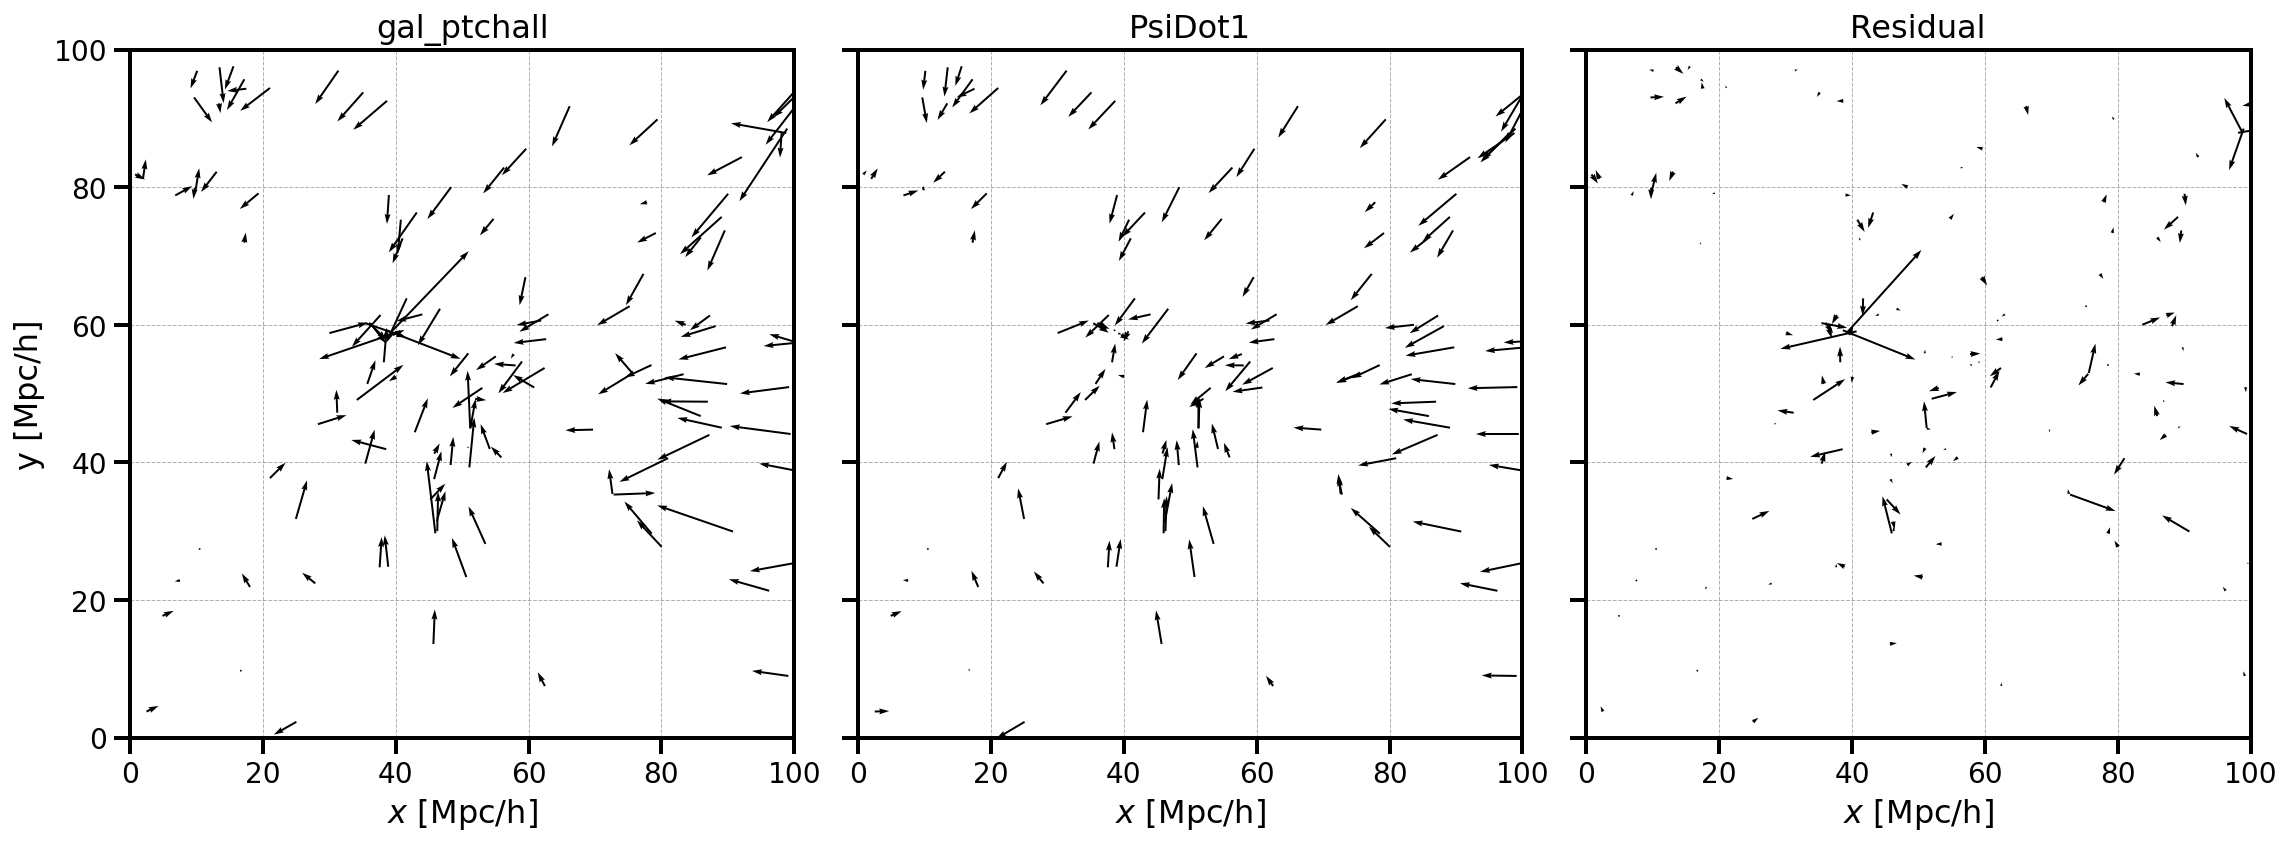

In [12]:
# plot again, without recomputing fields
plot_vectors(D0_target_cat, D0_target, D1_target, D2_target, D0_model, D1_model, D2_model, mtp_D0)

In [13]:
del D0_model, D1_model, D0_target, D1_target, D2_target, residual_D0, residual_D1, residual_D2, target_cat

## Compute rms of displacements sigma_D ##

In [14]:
# SLOW: compute
if True:
    ## ModelTargetPairs to plot
    model_target_pairs = []

    # Model=PsiDot, target=halo velocity
    #model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=halo_D0))
    #model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=DM_D0))
    #model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=halo_D0))
    #model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=DM_D0))
    #model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=halo_D0))
    
    if True:
        # PT challenge galaxies, different models
        for target in [gal_ptchall_D0]:
            #model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=target))
            #model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
            if False:
                model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))
                model_target_pairs.append(ModelTargetPair(model=PsiDot2_D0, target=target))
                model_target_pairs.append(ModelTargetPair(model=PsiDot2_shiftedbyPsi1_D0, target=target))
                model_target_pairs.append(ModelTargetPair(model=PsiDot1_shiftedbyPsi2_D0, target=target))
                model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
                model_target_pairs.append(ModelTargetPair(model=delta2LPT_D0, target=target))
            
            if False:
                # PTchallenge galaxies, G2[delta_Z] model
                model_target_pairs.append(ModelTargetPair(model=theta2_of_deltalin_D0, target=gal_ptchall_subbox_D0))
                #model_target_pairs.append(ModelTargetPair(model=theta2_of_deltalin_D1, target=gal_ptchall_subbox_D1))
                model_target_pairs.append(ModelTargetPair(model=theta2_of_deltaZ_D0, target=gal_ptchall_subbox_D0))

            if True:
                # shfited PsiDot model
                model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))
        
            
    if False:
        # FOF halos with CM position and velocity 
        for target in [CM_halos_108_118_D0, CM_halos_118_128_D0, CM_halos_128_160_D0
        ]:
            #model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=target))
            #model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))

    if False:
        # FOF HOD
        target = gal_HOD_Zheng07_HandSeljak17
        model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=target))
        model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
        model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))
        
            
    if False:
        # Rockstar halos with mass cut
        for target in [rockstar_halos_108_118_D0, rockstar_halos_118_128_D0, rockstar_halos_128_160_D0
        ]:
            model_target_pairs.append(ModelTargetPair(model=deltalin_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=deltaZ_D0, target=target))
            model_target_pairs.append(ModelTargetPair(model=PsiDot1_D0, target=target))

            

    # START CALCULATION
    mtp_sigma_dict = OrderedDict()
    

    for mtp in model_target_pairs:
        Dmodel = mtp.readout_model_at_target_pos()
        Dtarget = mtp.get_target_val_at_target_pos().compute()
           
        print('Results for %s' % mtp.name)
        print('D target:', get_cstats_string(Dtarget))
        print('D model:', get_cstats_string(Dmodel))
        print('D residual: ', get_cstats_string(Dtarget-Dmodel))

        mtp_sigma_dict[mtp.name] = (mtp, {
            'sigma_D0_target': get_crms(Dtarget),
            'sigma_D0_model': get_crms(Dmodel),
            'sigma_D0_residual': get_crms(Dtarget-Dmodel)
        })
        
        #del Dmodel, Dtarget
        
#print('sigma_of_mtp:')
#print(sigma_of_mtp)

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/IC_LinearMesh_PsiDot1_0_intR0.00_extR0.00_SHIFTEDBY_IC_LinearMeshR0.23_a0.6250_Np1536_Nm1536_Ng512_CICavg
Apply rescale fac to PsiDot1_D0: 0.786295109993697
MESH PsiDot1_D0: rms, min, mean, max: 3.22473 -15.2871 -7.10665e-05 14.8861

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
Cuts removed -99.4867% of objects
Apply rescale factor: 0.011452
TARGET CATALOG gal_ptchall_D0: rms, min, mean, max: 3.86053 -28.1726 -0.0247806 37.8329

Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.bigfile
Nhalos: 10934998
Ngalaxies: 56125
Galaxy mass:  rms, min, mean, max: 0.365026 11.9082 13.1292 15.2379
Cuts removed -99.4867% of objects
Apply rescale factor: 0.011452
T

## rms residual displacement when removing worst galaxies ##

In [31]:
# remove outliers
residual = Dtarget-Dmodel
residual_no_outliers = residual[ np.abs(residual)<=3. ]
print(get_cstats_string(residual))
print(get_cstats_string(residual_no_outliers))

rms, min, mean, max: 2.04664 -26.5265 -0.0144805 34.7303
rms, min, mean, max: 1.13043 -2.99969 -0.00084381 2.9997


In [16]:
# sorted absolute value of residual
abs_residual = np.abs(residual)
abs_residual.sort()
Ngal = abs_residual.shape[0]

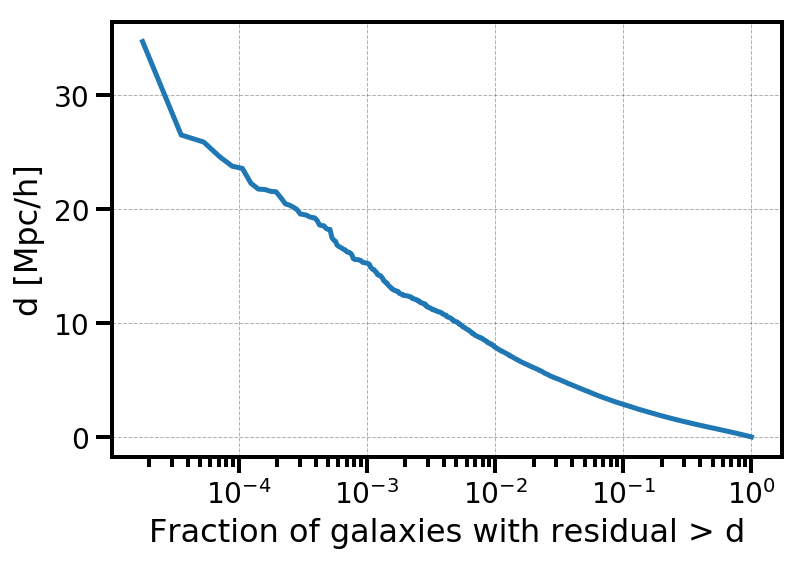

In [17]:
plt.semilogx(1.-np.array(range(Ngal))/float(Ngal), abs_residual)
plt.xlabel('Fraction of galaxies with residual > d')
plt.ylabel('d [Mpc/h]')
plt.savefig('../pdf/fraction_of_galaxies_with_large_residual.pdf')

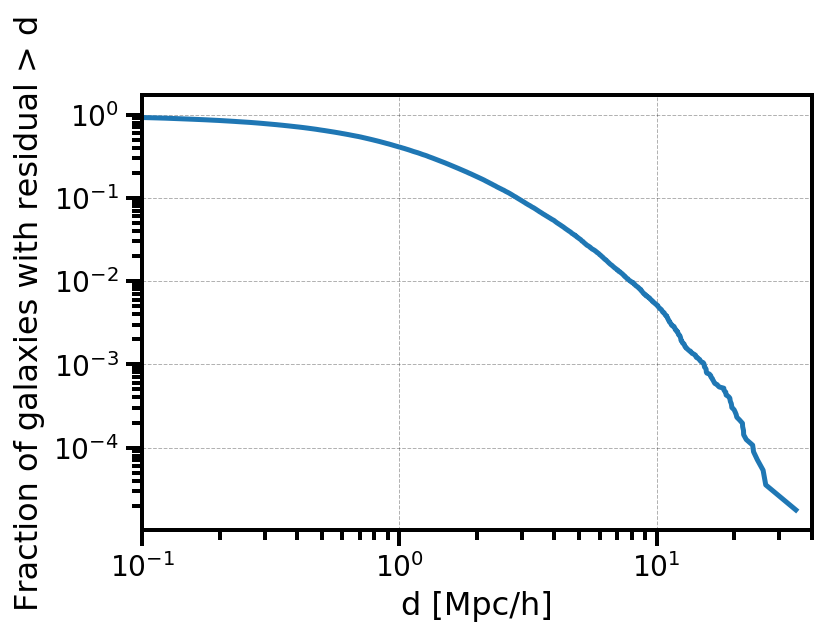

In [18]:
plt.loglog(abs_residual, 1.-np.array(range(Ngal))/float(Ngal))
plt.ylabel('Fraction of galaxies with residual > d')
plt.xlabel('d [Mpc/h]')
plt.xlim((0.1,40))
plt.savefig('../pdf/fraction_of_galaxies_with_large_residual2.pdf')

rms residual 2.046637758771649


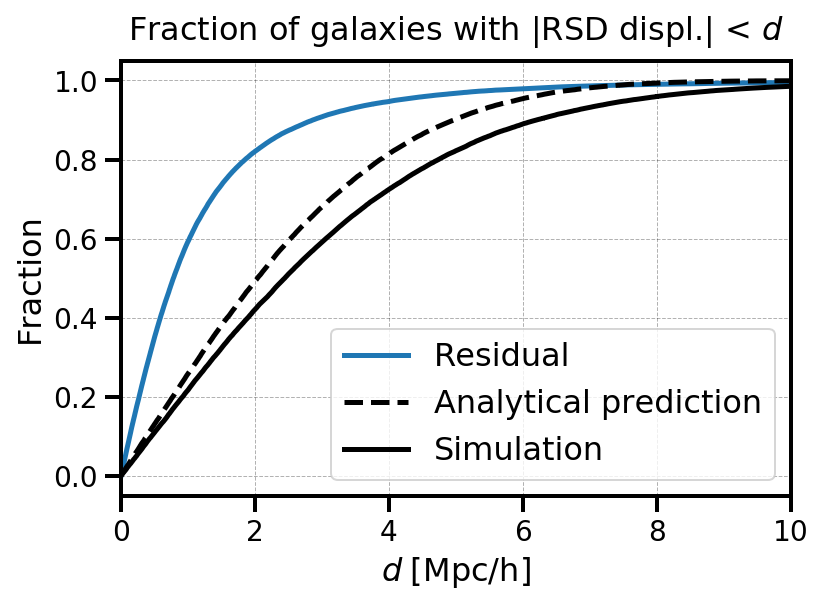

In [45]:
#plt.figure(figsize=(5,4))
abs_residual = np.abs(residual)
abs_residual.sort()
plt.semilogx(abs_residual, np.array(range(Ngal))/float(Ngal), label='Residual')

abs_model = np.abs(Dmodel)
abs_model.sort()
plt.semilogx(abs_model, np.array(range(Ngal))/float(Ngal), 'k--', label='Analytical prediction')

#abs_target = np.abs(Dtarget)
abs_target = np.abs(Dtarget)
abs_target.sort()
plt.semilogx(abs_target, np.array(range(Ngal))/float(Ngal), 'k-', label='Simulation')



stddev = np.std(residual)
print('rms residual', stddev)
#from scipy.stats import norm
#gaussian_residual = 1./np.sqrt(2.*np.pi*stddev**2) * np.exp(-0.5*(abs_residual/stddev)**2)
#plt.semilogx(norm.cdf(abs_residual, scale=stddev), np.array(range(Ngal))/float(Ngal), 'k--')

plt.ylabel(r'Fraction')
plt.title(r'Fraction of galaxies with |RSD displ.| < $d$', fontsize=16, y=1.02)
#plt.ylabel('Cumulative histogram')
plt.xlabel(r'$d\;$[Mpc/h]')
plt.legend(loc='best')
ax = plt.gca()
ax.set_xscale('linear')
plt.xlim((0,10))


plt.savefig('../pdf/fraction_of_galaxies_with_small_residual.pdf')

In [28]:
# print percentiles of residual RSD displacement
for fract in [0.5,0.87,0.9,0.95,0.99, 0.999, 0.9999]:
    print('%gth percentile: %.2f Mpc/h' % (100*fract, abs_residual[int(fract*float(Ngal))]))

50th percentile: 0.78 Mpc/h
87th percentile: 2.46 Mpc/h
90th percentile: 2.86 Mpc/h
95th percentile: 4.10 Mpc/h
99th percentile: 7.90 Mpc/h
99.9th percentile: 15.26 Mpc/h
99.99th percentile: 23.59 Mpc/h


In [38]:
# print rms if keeping best percentile of residual RSD displacement
for fract in [0.5,0.87,0.9,0.95,0.99, 0.999, 0.9999]:
    this_max_displ = abs_residual[int(fract*float(Ngal))]
    print('Remove the worst %g%% of galaxies: rms residual RSD displacement=%.2f Mpc/h' % (
        100*(1-fract), 
        get_crms(residual[np.abs(residual)<=this_max_displ])
    ))
print('Keep all:', get_crms(residual[:]))

Remove the worst 50% of galaxies: rms residual RSD displacement=0.42 Mpc/h
Remove the worst 13% of galaxies: rms residual RSD displacement=1.01 Mpc/h
Remove the worst 10% of galaxies: rms residual RSD displacement=1.10 Mpc/h
Remove the worst 5% of galaxies: rms residual RSD displacement=1.33 Mpc/h
Remove the worst 1% of galaxies: rms residual RSD displacement=1.70 Mpc/h
Remove the worst 0.1% of galaxies: rms residual RSD displacement=1.96 Mpc/h
Remove the worst 0.01% of galaxies: rms residual RSD displacement=2.03 Mpc/h
all: 2.046637758771649


Result: Need to remove the worst 13% of galaxies to reduce the rms residual by a factor of 2.

So about half the rms (1Mpc/h) comes from worst 13% of galaxies (these have residual displacement >2.5Mpc/h), the other half of the rms (1Mpc/h) comes from the best 87% of galaxies (these have residual displacement <2.5Mpc/h).

Better PT models could improve galaxies with residual displacement <2.5Mpc/h, which could reduce the rms by a factor of 2.

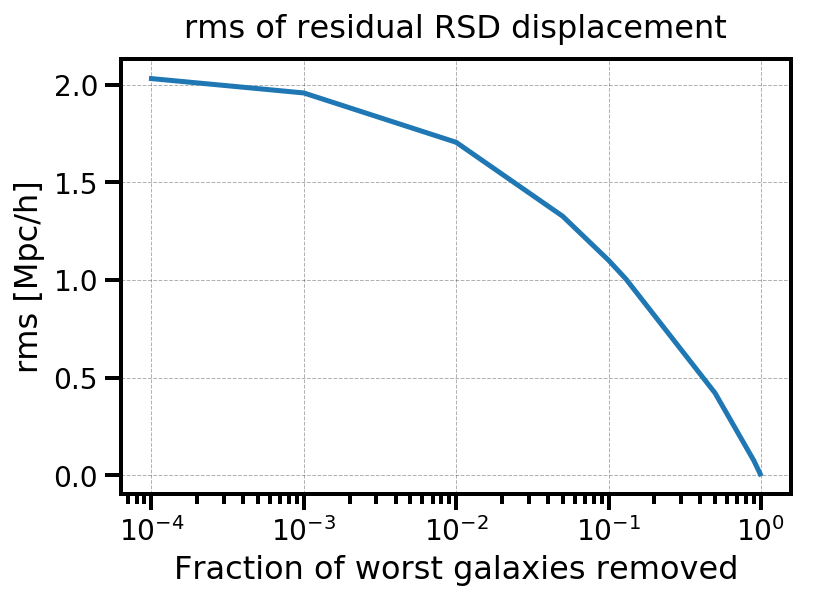

In [49]:
x = []
y = []
for fract in [0.01,0.1,0.5,0.87,0.9,0.95,0.99, 0.999, 0.9999]:
    this_max_displ = abs_residual[int(fract*float(Ngal))]
    x.append(1*(1-fract))
    y.append(get_crms(residual[np.abs(residual)<=this_max_displ]))
plt.semilogx(np.array(x), np.array(y))
plt.xlabel('Fraction of worst galaxies removed')
#plt.ylabel('Rms residual RSD displ. [Mpc/h]')
plt.title('rms of residual RSD displacement', y=1.02, fontsize=16)
plt.ylabel('rms [Mpc/h]')
plt.savefig('../pdf/rms_displ_residual_with_worst_gals_removed.pdf')

In [ ]:
del Dmodel, Dtarget

In [ ]:
# print results in table
from IPython.display import display, Math, Latex

tex_names['halos_10.8_11.8_D0'] = r'Peak FOF halos $\log M\!=\!10.8\!-\!11.8$'
tex_names['halos_11.8_12.8_D0'] = r'Peak FOF halos $\log M\!=\!11.8\!-\!12.8$'
tex_names['halos_12.8_16.0_D0'] = r'Peak FOF halos $\log M\!\ge\!12.8$'
tex_names['CM_halos_10.8_11.8_D0'] = r'CM FOF halos $\log M\!=\!10.8\!-\!11.8$'
tex_names['CM_halos_11.8_12.8_D0'] = r'CM FOF halos $\log M\!=\!11.8\!-\!12.8$'
tex_names['CM_halos_12.8_16.0_D0'] = r'CM FOF halos $\log M\!\ge\!12.8$'
tex_names['rockstar_halos_10.8_11.8_D0'] = r'Rockstar halos $\log M\!=\!10.8\!-\!11.8$'
tex_names['rockstar_halos_11.8_12.8_D0'] = r'Rockstar halos $\log M\!=\!11.8\!-\!12.8$'
tex_names['rockstar_halos_12.8_16.0_D0'] = r'Rockstar halos $\log M\!\ge\!12.8$'
tex_names['gal_HOD_Zheng07_HandSeljak17'] = r'HOD galaxies from FOF halos'
tex_names['gal_ptchall_D0'] = r'PT challenge galaxies'
tex_names['PsiDot1_D0'] = r'$f\dot\psi_0^{[1]}(q+\psi^{[1]})$'
tex_names['PsiDot2_D0'] = r'$f\dot\psi_0^{[2]}(q+\psi^{[2]})$'
tex_names['PsiDot2_shiftedbyPsi1_D0'] = r'$f\dot\psi_0^{[2]}(q+\psi^{[1]})$'
tex_names['PsiDot1_shiftedbyPsi2_D0'] = r'$f\dot\psi_0^{[1]}(q+\psi^{[2]})$'
tex_names['deltaZ_D0'] = r'$f\nabla_0\nabla^{-2} \delta_Z(x)$'
tex_names['delta2LPT_D0'] = r'$f\nabla_0\nabla^{-2} \delta_\text{2LPT}(x)$'
tex_names['deltalin_D0'] = r'$f\nabla_0\nabla^{-2} \delta_1$'

outlines = []
for mtp, sigma_dict in mtp_sigma_dict.values():
    outlines.append(r"%s && %s && %.2f && %.2f && %.2f && %.2f \\ " % (
        tex_names.get(mtp.target.name, mtp.target.name),
        tex_names.get(mtp.model.name, mtp.model.name),
        sigma_dict['sigma_D0_target'], 
        sigma_dict['sigma_D0_model'], 
        sigma_dict['sigma_D0_residual'],
        sigma_dict['sigma_D0_residual']/sigma_dict['sigma_D0_target']
    ))
    
for line in outlines:
    display(Latex(line))
    


In [ ]:
print('\n'.join(outlines))

In [ ]:
2.8/4.47

In [ ]:
int('-3')

In [ ]:
['a','b'] + ['c']